# Use of learnt parameters ($\lambda$, learning rate & iterations) on the full dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def add_bias(features):
    size = features.shape[0]
    new_array = np.c_[np.ones(size), features]
    return new_array

In [4]:
x_train = mnist.train.images
X_biased = add_bias(x_train)
y_train = mnist.train.labels

x_test = mnist.test.images
X_test_biased = add_bias(x_test)
y_test = mnist.test.labels


In [5]:
#config
L1 = 2.0 #regularization parameter
learning_rate = 0.0002
training_epochs = 10000

In [6]:
sample_n, params_n = np.shape(X_biased) #Nx785 if images are 28x28 pixles
layer2_n = 25 

# inputs
y_ = tf.placeholder(tf.float64, [None, 10], name='y_input')
X_ = tf.placeholder(tf.float64, [None, params_n], name='x_input')

# weights
W1 = tf.Variable(tf.truncated_normal((params_n, layer2_n), dtype=tf.float64), name='W_1')
W2 = tf.Variable(tf.truncated_normal((layer2_n+1, 10), dtype=tf.float64), name='W_2')

# 1st layer
z2 = tf.matmul(X_,W1)
a2 = tf.sigmoid(z2)
a2_ = tf.concat([tf.ones([sample_n, 1], tf.float64), a2], axis=1)

#2nd layer
z3 = tf.matmul(a2_,W2)
h_ = tf.sigmoid(z3)
    

# cost function
cost = [tf.reduce_mean(tf.multiply(-y_,tf.log(h_))-
                      tf.multiply(1-y_,tf.log(1-h_)))+
        0.5*L1/sample_n*tf.reduce_sum(tf.square(W1[1:,:]))+
        0.5*L1/sample_n*tf.reduce_sum(tf.square(W2[1:,:]))][0]


def d_sig(z):
    return tf.multiply(tf.sigmoid(z), 1-tf.sigmoid(z))

# BackProp
delta3 = tf.multiply(h_-y_, d_sig(z3))
delta2 = tf.multiply(tf.matmul(delta3, tf.transpose(W2[1:,:])), d_sig(z2))

reg_W2 = tf.concat([tf.zeros([1,10], dtype=tf.float64), L1/sample_n*W2[1:,:]], 0)
dJ_W2 = tf.matmul(tf.transpose(a2_), delta3)+reg_W2

reg_W1 = tf.concat([tf.zeros([1,25], dtype=tf.float64), L1/sample_n*W1[1:,:]], 0)
dJ_W1 = tf.matmul(tf.transpose(X_), delta2)+reg_W1


# updating  
update = [tf.assign(W1, tf.subtract(W1,learning_rate*dJ_W1)),
         tf.assign(W2, tf.subtract(W2,learning_rate*dJ_W2))]

#with tf.name_scope('Train'):
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
# Accuracy
y_pred_pf = tf.equal(tf.argmax(h_,1), tf.argmax(y_,1))
y_pred_pf_float = tf.cast(y_pred_pf, tf.float64)
accuracy = tf.reduce_mean(y_pred_pf_float)

cost_history = []
accuracy_history = []

In [ ]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for epoch in range(training_epochs):
        
    sess.run(update, feed_dict={X_:X_biased, y_:y_train})
    cost_value = sess.run(cost, feed_dict={X_:X_biased, y_:y_train})
    acrcy_value = sess.run(accuracy, feed_dict={X_:X_biased, y_:y_train})
    cost_history.append(cost_value)
    accuracy_history.append(acrcy_value)

weights1_reg = sess.run(W1)
weights2_reg = sess.run(W2)
sess.close()

In [18]:
# save parameters
np.save('weight1_reg', weights1_reg)
np.save('weight2_reg', weights2_reg)

# Evaluating the trained model - 96.19%

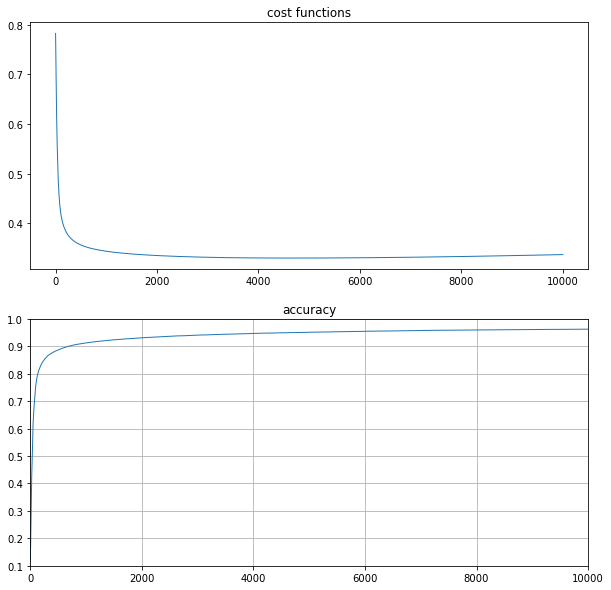

Accuracy of the trained model on the training data is 96.18909090909091%


In [24]:
fig, ax = plt.subplots(figsize=(10,10))

plt.xlabel('iterations',fontsize=16)
plt.ylabel('Error', fontsize=16)

plt.subplot(2,1,1)
plt.title('cost functions')
plt.plot(range(training_epochs), cost_history, linewidth=1)
plt.subplot(2,1,2)
plt.title('accuracy')
plt.axis([0,10000,0.1,1])
plt.grid(True)
plt.plot(range(training_epochs), accuracy_history, linewidth=1)

plt.show()

print('Accuracy of the trained model on the training data is {}%'.format(accuracy_history[-1]*100))

# Evaluating model performance on the test data - 93.74%

In [22]:
sample_n, params_n = np.shape(X_test_biased) #Nx785 if images are 28x28 pixles
layer2_n = 25

z2 = np.matmul(X_test_biased,weights1_reg)
a2 = scipy.special.expit(z2)
a2_ = np.concatenate([np.ones([sample_n, 1], np.float64), a2], axis=1)

#2nd layer
z3 = np.matmul(a2_,weights2_reg)
h_ = scipy.special.expit(z3)

y_pred_pf = np.equal(np.argmax(h_,1), np.argmax(y_test,1))
#y_pred_pf_float = tf.cast(y_pred_pf, tf.float64)
accuracy = np.mean(y_pred_pf)

#test_accuracy = sess.run(t_accuracy, feed_dict={X_:X_test_biased, y_:y_test})
print("The accuracy of the trained model on the test data is {}%". format(accuracy*100))

The accuracy of the trained model on the test data is 93.74%
